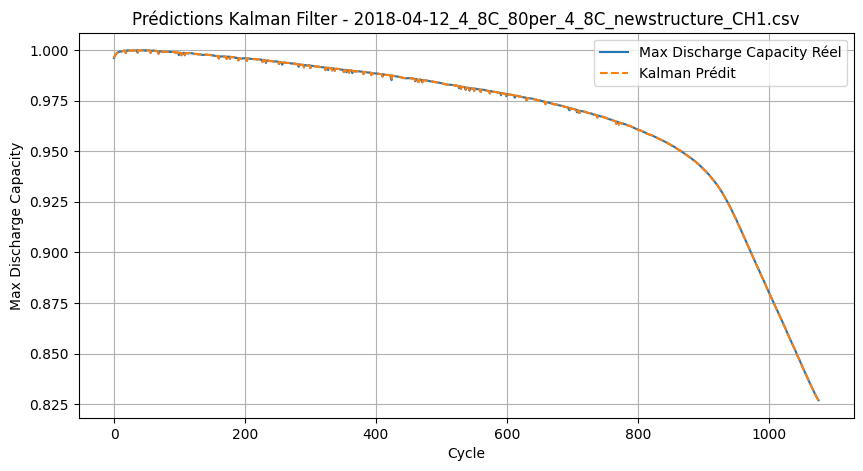

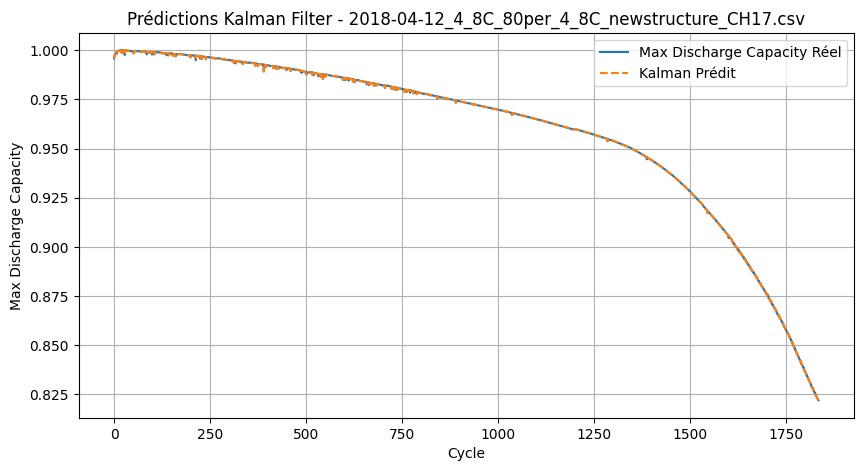

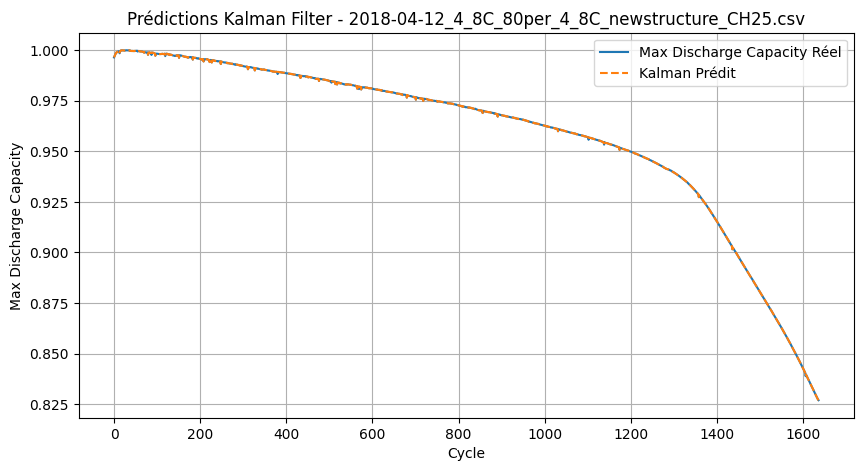

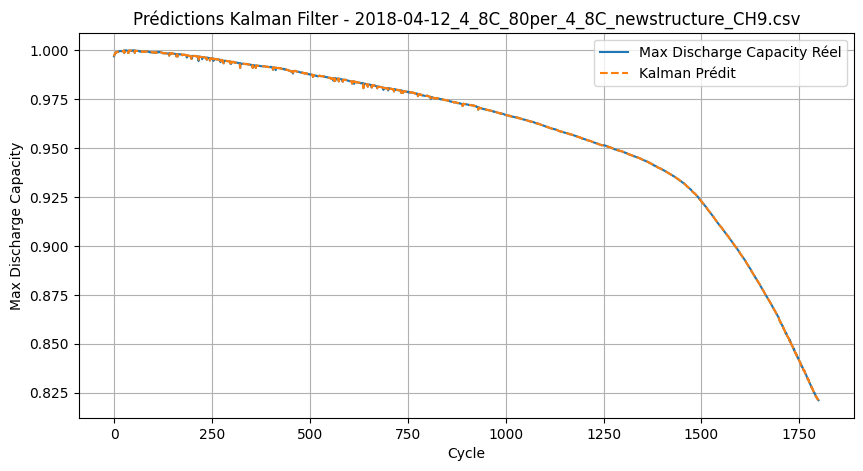

MSE moyen pour le modèle de Kalman: 0.00016049353620035636


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error

# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'

# Lister tous les fichiers CSV dans le répertoire donné
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Sélectionner les fichiers pour l'entraînement et le test
train_files = csv_files[:12]  # Les 12 premiers fichiers pour l'entraînement
test_files = csv_files[12:]   # Les 5 derniers fichiers pour le test

# Fonction pour entraîner un filtre de Kalman sur les données de capacité de décharge
def train_kalman_filter(train_data):
    # Initialiser le filtre de Kalman avec des paramètres simplifiés
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
    
    # Réduire le nombre d'itérations d'EM pour accélérer l'entraînement
    kf = kf.em(train_data, n_iter=2)  # Réduire à 5 itérations d'EM
    return kf

# Entraîner le filtre de Kalman sur les fichiers d'entraînement
y_train_total = []

for csv_file in train_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    y_train = df['Discharge_Capacity']
    y_train_total.append(y_train)

# Concaténer les données d'entraînement
y_train = pd.concat(y_train_total, axis=0).values

# Réduire le nombre de données d'entraînement si nécessaire
if len(y_train) > 10000:
    y_train = y_train[::10]  # Sous-échantillonner les données pour accélérer l'entraînement

# Entraîner le filtre de Kalman sur les données de capacité de décharge
kf = train_kalman_filter(y_train.reshape(-1, 1))

# Tester le modèle de Kalman sur les fichiers de test
mse_list = []
for csv_file in test_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    y_test = df['Discharge_Capacity'].values
    cycle_index = df['Cycle_Index']

    # Utiliser le filtre de Kalman pour faire des prédictions
    kalman_pred, _ = kf.filter(y_test.reshape(-1, 1))

    # Calculer le MSE entre les vraies valeurs et les prédictions
    mse = mean_squared_error(y_test, kalman_pred)
    mse_list.append(mse)

    # Calculer le max discharge capacity par cycle
    y_test_max_per_cycle = df.groupby('Cycle_Index')['Discharge_Capacity'].max()
    kalman_pred_max_per_cycle = pd.Series(kalman_pred.flatten()).groupby(cycle_index).max()

    # Afficher les graphes pour chaque fichier
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_max_per_cycle.values, label='Max Discharge Capacity Réel')
    plt.plot(kalman_pred_max_per_cycle.values, label='Kalman Prédit', linestyle='--')
    plt.xlabel('Cycle')
    plt.ylabel('Max Discharge Capacity')
    plt.title(f'Prédictions Kalman Filter - {csv_file}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Afficher le MSE moyen sur les fichiers de test
print(f"MSE moyen pour le modèle de Kalman: {np.mean(mse_list)}")


C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


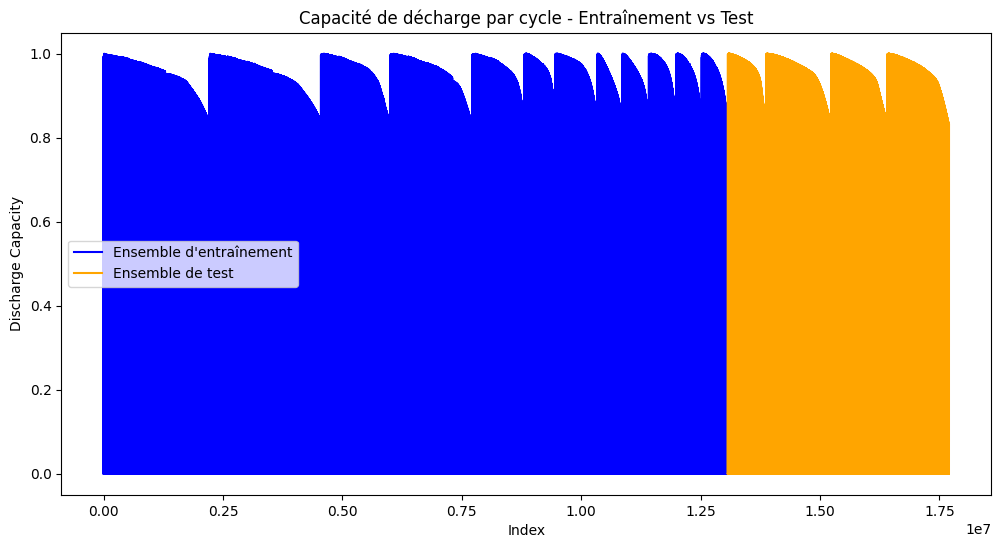

In [19]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'

# Lister tous les fichiers CSV dans le répertoire donné
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Sélectionner les fichiers pour l'entraînement et le test
train_files = csv_files[:12]  # Les 12 premiers fichiers pour l'entraînement
test_files = csv_files[12:]   # Les 5 derniers fichiers pour le test

# Initialiser les ensembles de données d'entraînement
y_train_total = []
y_test_total = []

# Préparer les données d'entraînement
for csv_file in train_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    y = df['Discharge_Capacity']
    y_train_total.append(y)

# Préparer les données de test
for csv_file in test_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    y = df['Discharge_Capacity']
    y_test_total.append(y)

# Concaténer les données d'entraînement et de test
y_train = pd.concat(y_train_total, axis=0).reset_index(drop=True)
y_test = pd.concat(y_test_total, axis=0).reset_index(drop=True)

# Tracer les données
plt.figure(figsize=(12, 6))

# Graphe pour les données d'entraînement
plt.plot(y_train, label='Ensemble d\'entraînement', color='blue')

# Graphe pour les données de test
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Ensemble de test', color='orange')

# Ajouter les labels et la légende
plt.title('Capacité de décharge par cycle - Entraînement vs Test')
plt.xlabel('Index')
plt.ylabel('Discharge Capacity')
plt.legend()

# Afficher le graphe
plt.show()


Préparation des données d'entraînement: 100%|██████████| 12/12 [00:19<00:00,  1.61s/it]
C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
104307/104307 ━━━━━━━━━━━━━━━━━━━━ 708s 7ms/step - loss: 0.0124
Epoch 2/5
104307/104307 ━━━━━━━━━━━━━━━━━━━━ 712s 7ms/step - loss: 0.0049
Epoch 3/5
104307/104307 ━━━━━━━━━━━━━━━━━━━━ 1115s 11ms/step - loss: 0.0033
Epoch 4/5
104307/104307 ━━━━━━━━━━━━━━━━━━━━ 774s 7ms/step - loss: 0.0026
Epoch 5/5
104307/104307 ━━━━━━━━━━━━━━━━━━━━ 1434s 14ms/step - loss: 0.0023


Test du modèle:   0%|          | 0/4 [00:00<?, ?it/s]

25412/25412 ━━━━━━━━━━━━━━━━━━━━ 122s 5ms/step
Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH1.csv
Mean Squared Error (MSE): 0.017352153372019015
Mean Absolute Error (MAE): 0.062211120232684276
R-squared (R²): 0.883425062963633


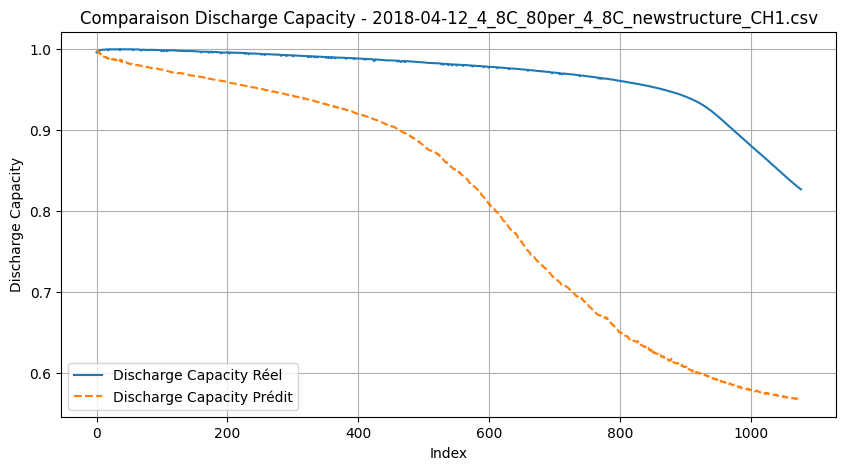

Test du modèle:  25%|██▌       | 1/4 [02:18<06:54, 138.31s/it]

43009/43009 ━━━━━━━━━━━━━━━━━━━━ 201s 5ms/step
Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH17.csv
Mean Squared Error (MSE): 0.035197896156518006
Mean Absolute Error (MAE): 0.09841251281501823
R-squared (R²): 0.7600658457743651


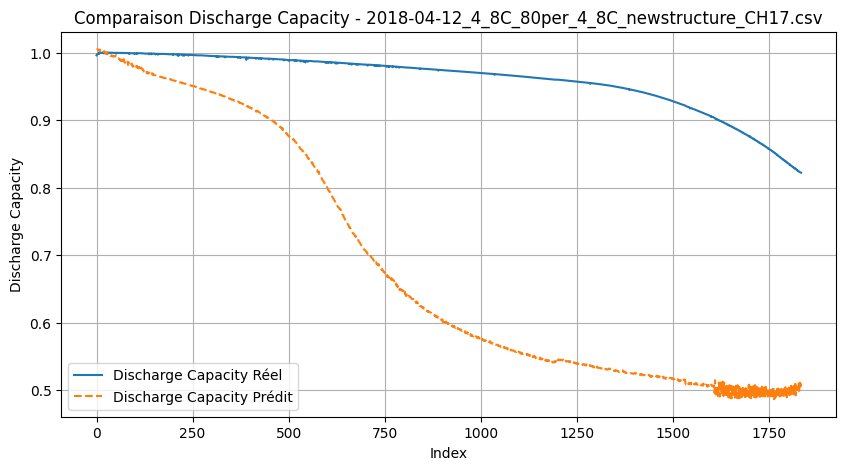

Test du modèle:  50%|█████     | 2/4 [06:05<06:21, 190.76s/it]

37112/37112 ━━━━━━━━━━━━━━━━━━━━ 174s 5ms/step
Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH25.csv
Mean Squared Error (MSE): 0.030786090379392204
Mean Absolute Error (MAE): 0.08840515244324723
R-squared (R²): 0.783096552207841


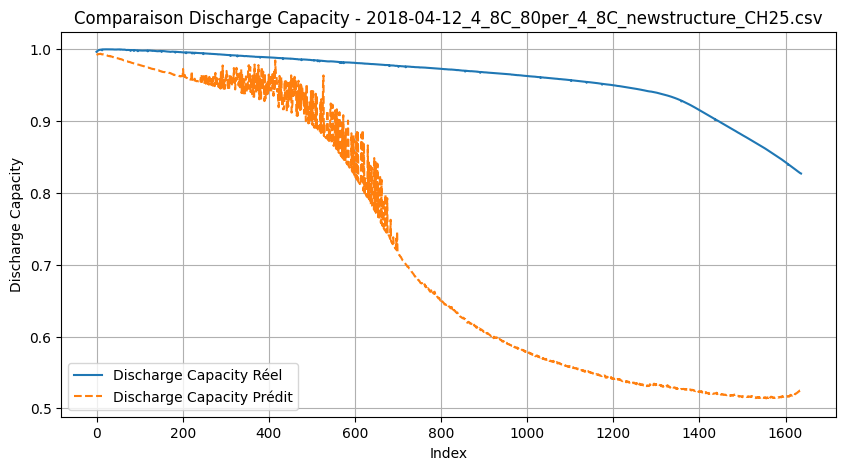

Test du modèle:  75%|███████▌  | 3/4 [09:22<03:13, 193.50s/it]

41032/41032 ━━━━━━━━━━━━━━━━━━━━ 189s 5ms/step
Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH9.csv
Mean Squared Error (MSE): 0.032448965071454505
Mean Absolute Error (MAE): 0.09288803928978323
R-squared (R²): 0.7716690865178302


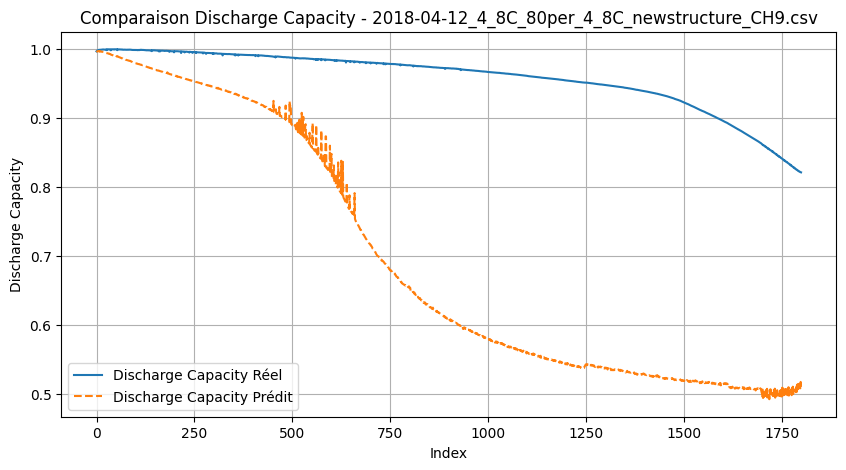

Test du modèle: 100%|██████████| 4/4 [12:54<00:00, 193.73s/it]


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Fonction pour créer des fenêtres temporelles
def create_sequences(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'

# Lister tous les fichiers CSV dans le répertoire donné
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Sélectionner les fichiers pour l'entraînement et le test
train_files = csv_files[:12]  # Les 12 premiers fichiers pour l'entraînement
test_files = csv_files[12:]   # Les fichiers restants pour le test

# Initialiser les ensembles de données d'entraînement
X_train_total = []
y_train_total = []
scaler = MinMaxScaler(feature_range=(0, 1))

# Préparer les données d'entraînement
for csv_file in tqdm(train_files, desc="Préparation des données d'entraînement"):
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    
    # Normalisation des données
    df_scaled = scaler.fit_transform(df.drop(columns=['Discharge_Capacity']))
    X = df_scaled
    y = df['Discharge_Capacity'].values
    
    X_train_total.append(X)
    y_train_total.append(y)

# Concaténer les données d'entraînement
X_train = np.concatenate(X_train_total, axis=0)
y_train = np.concatenate(y_train_total, axis=0)

# Créer des séquences avec time_steps = 5
time_steps = 5
X_train, y_train = create_sequences(X_train, y_train, time_steps)

# Créer et entraîner le modèle LSTM avec des couches supplémentaires et du Dropout
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout pour éviter le surapprentissage
model.add(LSTM(25, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Entraîner le modèle avec plus d'époques
history = model.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1)

# Sauvegarder la structure du modèle en JSON et les poids
model_structure = model.to_json()
model_path_json = 'C:\\Users\\pc\\Desktop\\Models\\lstm_structure.json'
with open(model_path_json, 'w') as json_file:
    json_file.write(model_structure)

# Sauvegarder les poids du modèle avec l'extension correcte
model_weights_path = 'C:\\Users\\pc\\Desktop\\Models\\lstm_weights.weights.h5'
model.save_weights(model_weights_path)

# Tester le modèle sur chaque fichier de test
for csv_file in tqdm(test_files, desc="Test du modèle"):
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    
    # Normalisation des données de test
    X_test_scaled = scaler.transform(df.drop(columns=['Discharge_Capacity']))
    y_test = df['Discharge_Capacity'].values
    
    # Créer des séquences de test
    X_test, y_test = create_sequences(X_test_scaled, y_test, time_steps)

    # Faire des prédictions
    lstm_pred = model.predict(X_test)
    
    # Limiter les prédictions entre 0 et 1
    lstm_pred = lstm_pred.flatten() 
    
    # Calculer les métriques
    mse = mean_squared_error(y_test, lstm_pred)
    mae = mean_absolute_error(y_test, lstm_pred)
    r2 = r2_score(y_test, lstm_pred)

    # Afficher les résultats
    print(f"Fichier de test: {csv_file}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")
    
    cycle_index = df['Cycle_Index']
    
    lstm_pred_max_per_cycle = pd.Series(lstm_pred).groupby(cycle_index[:len(lstm_pred)]).max()
    y_test_max_per_cycle = pd.Series(y_test).groupby(cycle_index[:len(y_test)]).max()
    
    # Tracer le graphique pour comparer les valeurs réelles et prédites
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_max_per_cycle, label='Discharge Capacity Réel')
    plt.plot(lstm_pred_max_per_cycle, label='Discharge Capacity Prédit', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Discharge Capacity')
    plt.title(f'Comparaison Discharge Capacity - {csv_file}')
    plt.legend()
    plt.grid(True)
    plt.show()


Modèle chargé et poids restaurés.


Test du modèle:   0%|          | 0/4 [00:00<?, ?it/s]

25412/25412 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step
Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH1.csv
Mean Squared Error (MSE): 0.005467788765991655
Mean Absolute Error (MAE): 0.020964528415135866
R-squared (R²): 0.9632663959649254


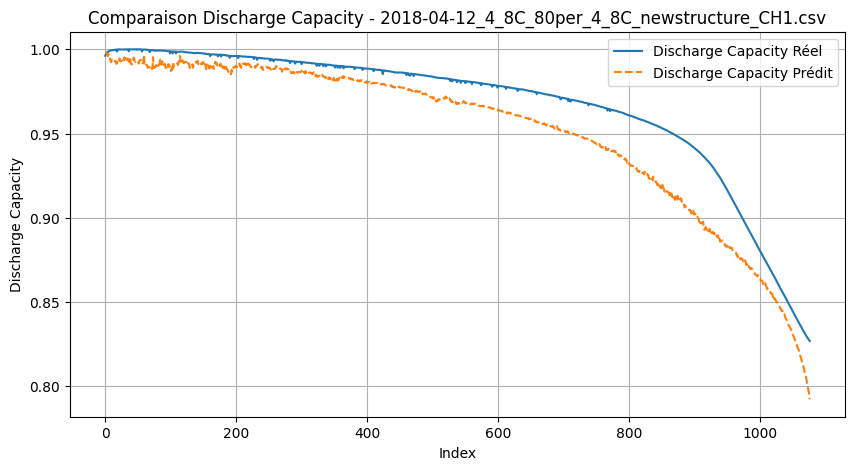

Test du modèle:  25%|██▌       | 1/4 [00:52<02:37, 52.64s/it]

43009/43009 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step
Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH17.csv
Mean Squared Error (MSE): 0.004689773548230749
Mean Absolute Error (MAE): 0.015680719842242067
R-squared (R²): 0.968031133315446


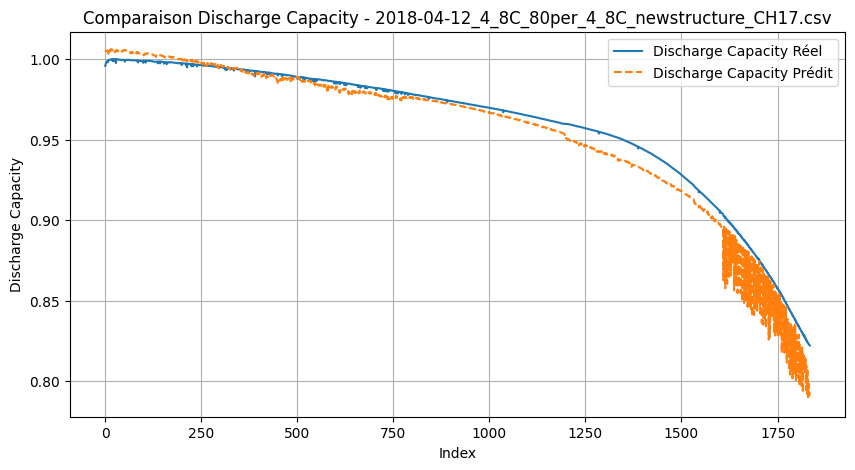

Test du modèle:  50%|█████     | 2/4 [02:20<02:27, 73.59s/it]

37112/37112 ━━━━━━━━━━━━━━━━━━━━ 110s 3ms/step
Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH25.csv
Mean Squared Error (MSE): 0.007338438057255982
Mean Absolute Error (MAE): 0.027836254423697734
R-squared (R²): 0.9482970232201521


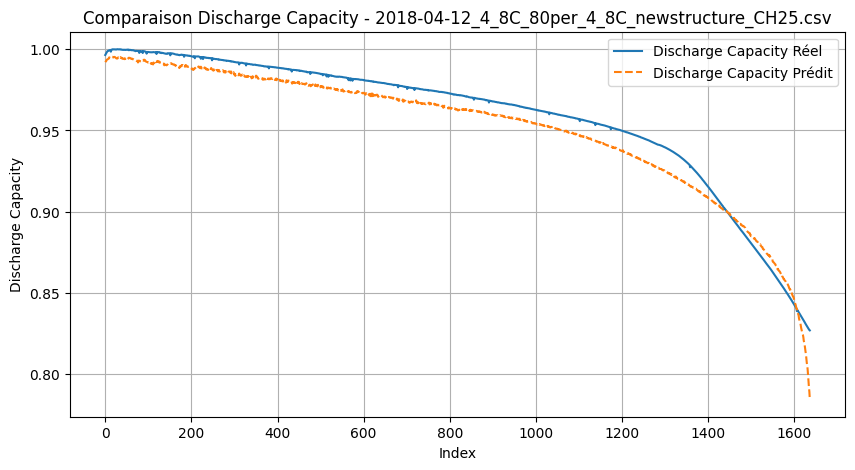

Test du modèle:  75%|███████▌  | 3/4 [04:42<01:44, 104.54s/it]

41032/41032 ━━━━━━━━━━━━━━━━━━━━ 136s 3ms/step
Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH9.csv
Mean Squared Error (MSE): 0.00595234135521486
Mean Absolute Error (MAE): 0.020674203411347687
R-squared (R²): 0.958115658357637


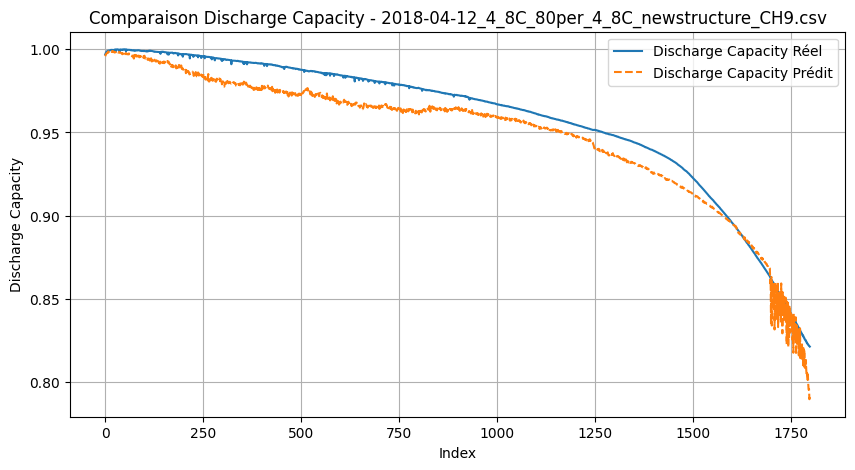

Test du modèle: 100%|██████████| 4/4 [07:21<00:00, 110.44s/it]


In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Fonction pour créer des séquences temporelles
def create_sequences(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Chemin vers le modèle LSTM sauvegardé
model_path_json = 'C:\\Users\\pc\\Desktop\\Models\\lstm_structure.json'
model_weights_path = 'C:\\Users\\pc\\Desktop\\Models\\lstm_weights.weights.h5'

# Charger le modèle LSTM à partir du fichier JSON
with open(model_path_json, 'r') as json_file:
    loaded_model_json = json_file.read()

model = model_from_json(loaded_model_json)

# Charger les poids dans le modèle
model.load_weights(model_weights_path)
print("Modèle chargé et poids restaurés.")

# Compiler le modèle (même après le chargement)
model.compile(optimizer='adam', loss='mse')

# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'

# Lister tous les fichiers CSV dans le répertoire donné
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Sélectionner les fichiers pour le test
test_files = csv_files[12:]   # Fichiers restants pour le test

# Initialiser le scaler (doit être identique à celui utilisé pendant l'entraînement)
scaler = MinMaxScaler(feature_range=(0, 1))

# Tester le modèle sur chaque fichier de test
for csv_file in tqdm(test_files, desc="Test du modèle"):
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)

    # Normalisation des données de test
    X_test_scaled = scaler.fit_transform(df.drop(columns=['Discharge_Capacity']))
    y_test = df['Discharge_Capacity'].values

    # Créer des séquences de test
    time_steps = 5
    X_test, y_test = create_sequences(X_test_scaled, y_test, time_steps)

    # Faire des prédictions
    lstm_pred = model.predict(X_test)
    
    # Limiter les prédictions entre 0 et 1
    lstm_pred = lstm_pred.flatten()

    # Calculer les métriques
    mse = mean_squared_error(y_test, lstm_pred)
    mae = mean_absolute_error(y_test, lstm_pred)
    r2 = r2_score(y_test, lstm_pred)

    # Afficher les résultats
    print(f"Fichier de test: {csv_file}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")

    cycle_index = df['Cycle_Index']

    lstm_pred_max_per_cycle = pd.Series(lstm_pred).groupby(cycle_index[:len(lstm_pred)]).max()
    y_test_max_per_cycle = pd.Series(y_test).groupby(cycle_index[:len(y_test)]).max()

    # Tracer le graphique pour comparer les valeurs réelles et prédites
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_max_per_cycle, label='Discharge Capacity Réel')
    plt.plot(lstm_pred_max_per_cycle, label='Discharge Capacity Prédit', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Discharge Capacity')
    plt.title(f'Comparaison Discharge Capacity - {csv_file}')
    plt.legend()
    plt.grid(True)
    plt.show()


### XGBOOST MODEL

C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [17:16:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH1.csv
Mean Squared Error (MSE): 0.007001603294497516
Mean Absolute Error (MAE): 0.024322053476968055
R-squared (R²): 0.9529618010373186


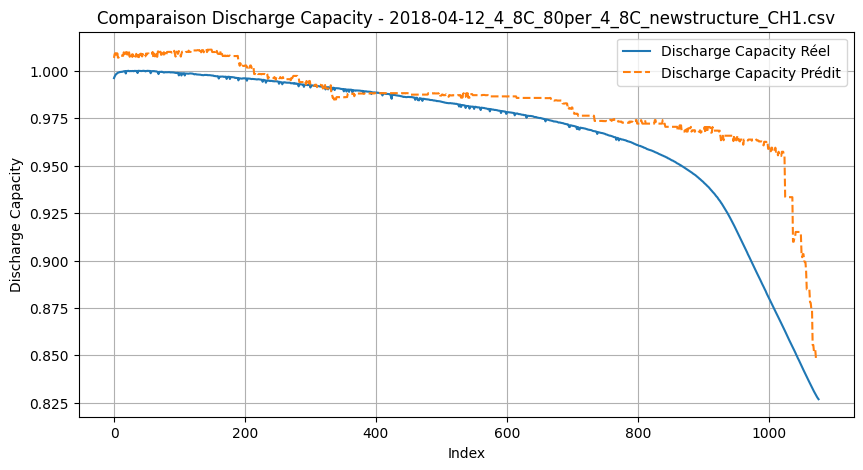

Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH17.csv
Mean Squared Error (MSE): 0.004250774436293489
Mean Absolute Error (MAE): 0.01926203100168868
R-squared (R²): 0.9710236125344617


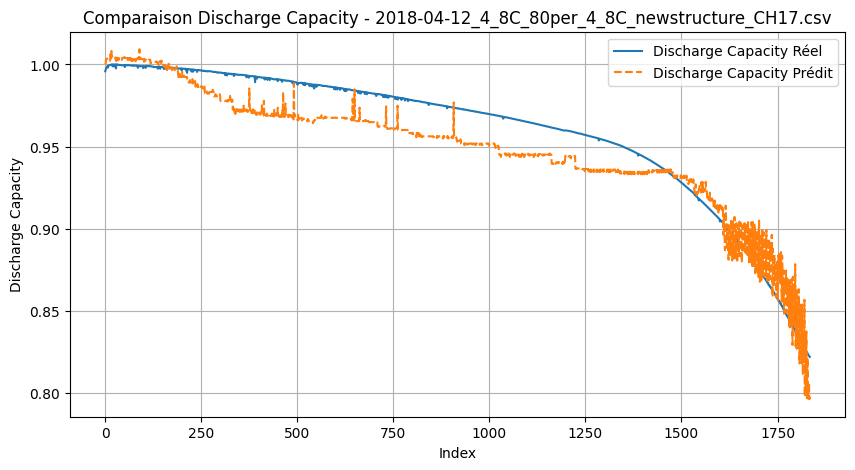

Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH25.csv
Mean Squared Error (MSE): 0.007521384335040067
Mean Absolute Error (MAE): 0.030406619186072587
R-squared (R²): 0.9470079564023033


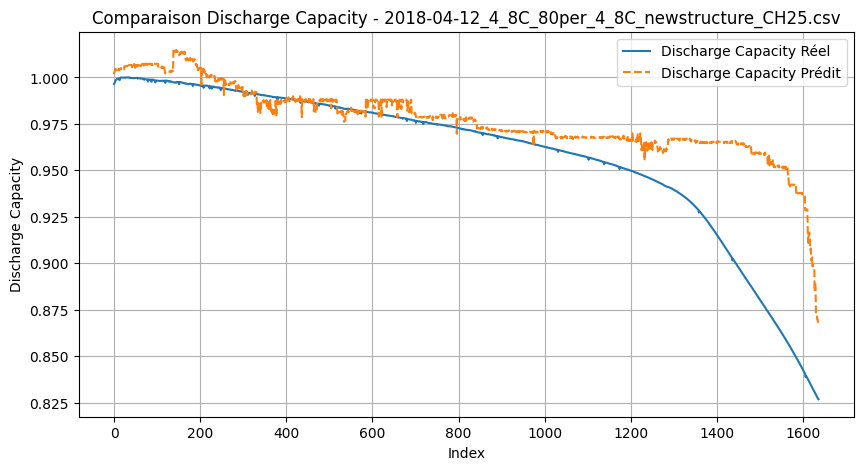

Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH9.csv
Mean Squared Error (MSE): 0.00591736628144999
Mean Absolute Error (MAE): 0.022988601616893086
R-squared (R²): 0.9583616807269708


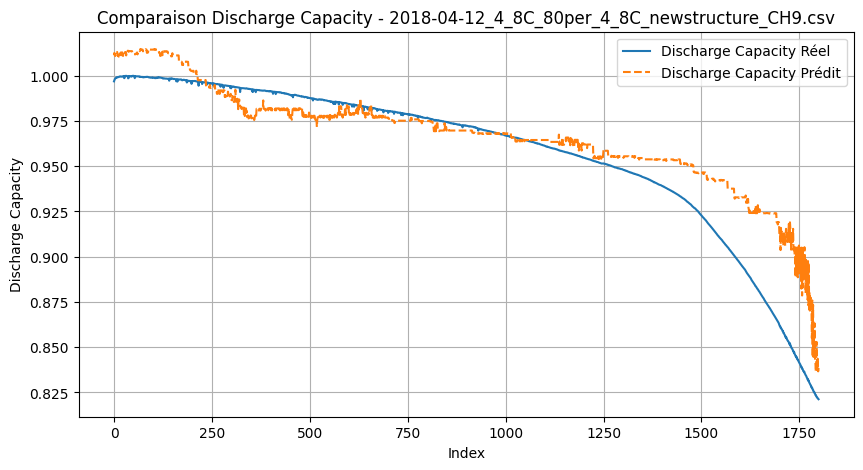

In [13]:
import os
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'

# Lister tous les fichiers CSV dans le répertoire donné
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Sélectionner les fichiers pour l'entraînement et le test
train_files = csv_files[:12]  # Les 12 premiers fichiers pour l'entraînement
test_files = csv_files[12:]   # Les 5 derniers fichiers pour le test

# Initialiser les ensembles de données d'entraînement
X_train_total = []
y_train_total = []

# Préparer les données d'entraînement
for csv_file in train_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    X = df.drop(columns=['Discharge_Capacity'])
    y = df['Discharge_Capacity']
    X_train_total.append(X)
    y_train_total.append(y)

# Concaténer les données d'entraînement
X_train = pd.concat(X_train_total, axis=0)
y_train = pd.concat(y_train_total, axis=0)

# Convertir en matrices DMatrix de XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Définir les paramètres du modèle
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 6,
    'alpha': 10,
    'n_estimators': 100
}

# Entraîner le modèle
model_xgb = xgb.train(params, dtrain, num_boost_round=100)
model_path='C:\\Users\\pc\\Desktop\\Models\\xgb.json'
model_xgb.save_model(model_path)
# Tester le modèle sur chaque fichier de test
for csv_file in test_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    X_test = df.drop(columns=['Discharge_Capacity'])
    y_test = df['Discharge_Capacity']
    
    # Convertir en matrice DMatrix de XGBoost
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Faire des prédictions
    xgb_pred = model_xgb.predict(dtest)
    
    # Limiter les prédictions entre 0.8 et 1
    #xgb_pred = np.clip(xgb_pred, 0.8, 1)
    
    # Convertir y_test en DataFrame pour aligner les indices
    y_test_df = pd.DataFrame(y_test).reset_index(drop=True)

    # Calculer les métriques
    mse = mean_squared_error(y_test_df, xgb_pred)
    mae = mean_absolute_error(y_test_df, xgb_pred)
    r2 = r2_score(y_test_df, xgb_pred)

    # Afficher les résultats
    print(f"Fichier de test: {csv_file}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")
    
    cycle_index = df['Cycle_Index']
    
    xgb_pred_max_per_cycle = pd.Series(xgb_pred).groupby(cycle_index).max()
    y_test_max_per_cycle = y_test.groupby(cycle_index).max()
    
    # Tracer le graphique pour comparer les valeurs réelles et prédites
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_max_per_cycle, label='Discharge Capacity Réel')
    plt.plot(xgb_pred_max_per_cycle, label='Discharge Capacity Prédit', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Discharge Capacity')
    plt.title(f'Comparaison Discharge Capacity - {csv_file}')
    plt.legend()
    plt.grid(True)
    plt.show()


### Linear Model

Modèle de régression linéaire sauvegardé à l'emplacement : Models\linear_regression_model.pkl
Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH1.csv
Mean Squared Error (MSE): 0.003390402919048766
Mean Absolute Error (MAE): 0.023899717989356386
R-squared (R²): 0.01954087545586536


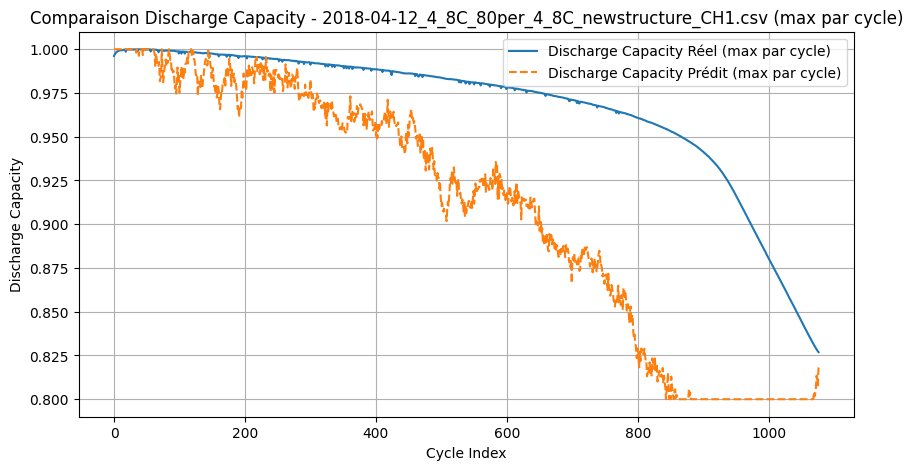

Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH17.csv
Mean Squared Error (MSE): 0.0032930681808945607
Mean Absolute Error (MAE): 0.023631384284523816
R-squared (R²): -0.025732310203994135


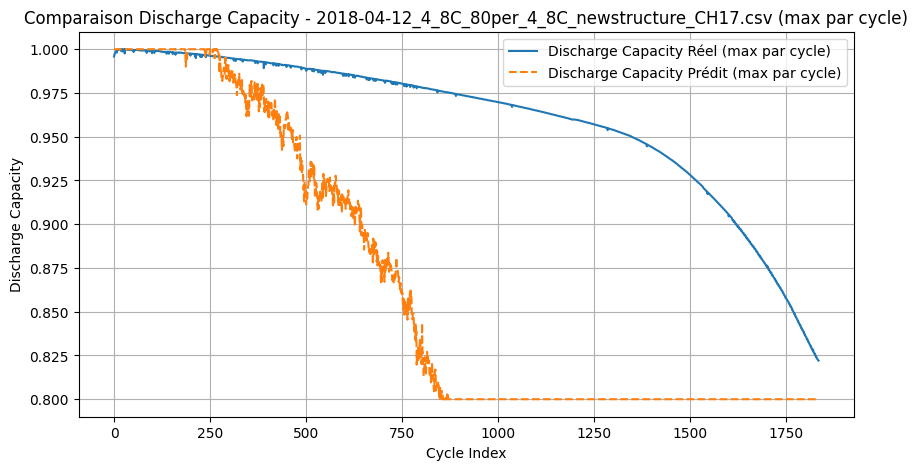

Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH25.csv
Mean Squared Error (MSE): 0.0030871003985677506
Mean Absolute Error (MAE): 0.022336639499042656
R-squared (R²): -0.04544930066924513


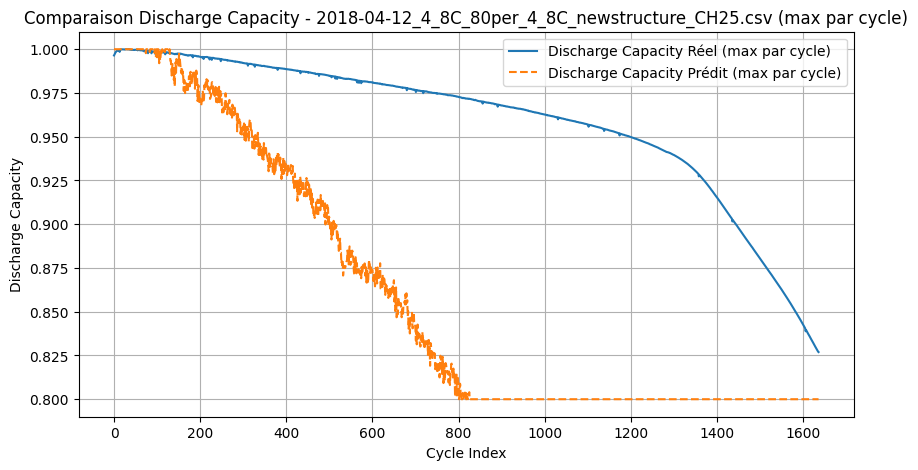

Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH9.csv
Mean Squared Error (MSE): 0.0028365373529854105
Mean Absolute Error (MAE): 0.0213194096771352
R-squared (R²): 0.037042847772354115


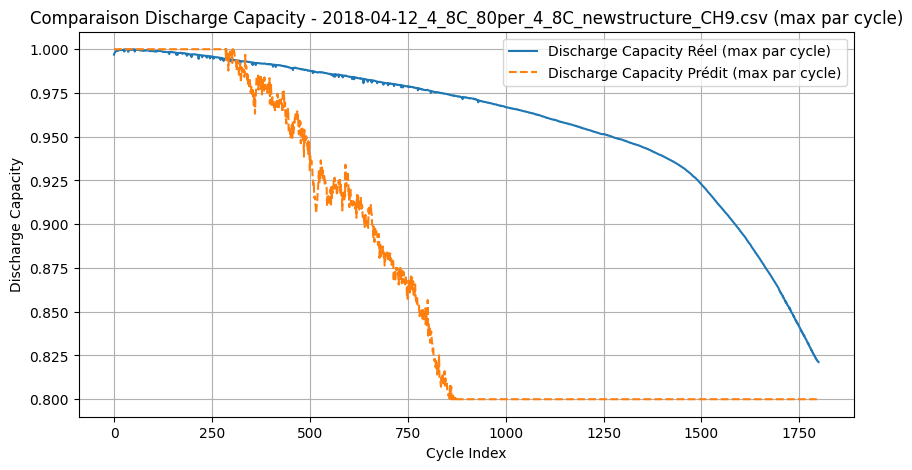

In [2]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import joblib
# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'

# Lister tous les fichiers CSV dans le répertoire donné
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Sélectionner les fichiers pour l'entraînement et le test
train_files = csv_files[:12]  # Les 12 premiers fichiers pour l'entraînement
test_files = csv_files[12:]   # Les 5 derniers fichiers pour le test

# Initialiser les ensembles de données d'entraînement
X_train_total = []
y_train_total = []

# Préparer les données d'entraînement
for csv_file in train_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    X = df.drop(columns=['Discharge_Capacity'])
    y = df['Discharge_Capacity']
    
    # Appliquer les contraintes sur y
    #y = np.clip(y, 0.8, 1)

    X_train_total.append(X)
    y_train_total.append(y)

# Concaténer les données d'entraînement
X_train = pd.concat(X_train_total, axis=0)
y_train = pd.concat(y_train_total, axis=0)

# Entraîner le modèle de régression linéaire
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)


# Créer le répertoire 'Models' s'il n'existe pas déjà
models_dir = 'C:\\Users\\pc\\Desktop\\Models'

model_save_path = os.path.join(models_dir, 'linear_regression_model.pkl')

joblib.dump(model_lr, model_save_path)

print(f"Modèle de régression linéaire sauvegardé à l'emplacement : {model_save_path}")

# Tester le modèle sur chaque fichier de test
for csv_file in test_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    X_test = df.drop(columns=['Discharge_Capacity'])
    y_test = df['Discharge_Capacity']
    
    # Appliquer les contraintes sur y_test
    y_test = np.clip(y_test, 0.8, 1)

    # Faire des prédictions
    lr_pred = model_lr.predict(X_test)

    # Appliquer les contraintes sur les prédictions
    lr_pred = np.clip(lr_pred, 0.8, 1)

    # Convertir y_test en DataFrame pour aligner les indices
    y_test_df = pd.DataFrame(y_test).reset_index(drop=True)

    # Calculer les métriques
    mse = mean_squared_error(y_test_df, lr_pred)
    mae = mean_absolute_error(y_test_df, lr_pred)
    r2 = r2_score(y_test_df, lr_pred)

    # Afficher les résultats
    print(f"Fichier de test: {csv_file}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")
    
    # Extraire le Cycle_Index
    cycle_index = df['Cycle_Index']

    # Prendre le maximum des prédictions et des valeurs réelles par cycle
    lr_pred_max_per_cycle = pd.Series(lr_pred).groupby(cycle_index).max()
    y_test_max_per_cycle = y_test.groupby(cycle_index).max()

    # Tracer le graphique pour comparer les valeurs réelles et prédites
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_max_per_cycle, label='Discharge Capacity Réel (max par cycle)')
    plt.plot(lr_pred_max_per_cycle, label='Discharge Capacity Prédit (max par cycle)', linestyle='--')
    plt.xlabel('Cycle Index')
    plt.ylabel('Discharge Capacity')
    plt.title(f'Comparaison Discharge Capacity - {csv_file} (max par cycle)')
    plt.legend()
    plt.grid(True)
    plt.show()


### Random forest

Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH1.csv
Mean Squared Error (MSE): 0.4389428268835981
Mean Absolute Error (MAE): 0.5792589803715383
R-squared (R²): -125.93638781197322


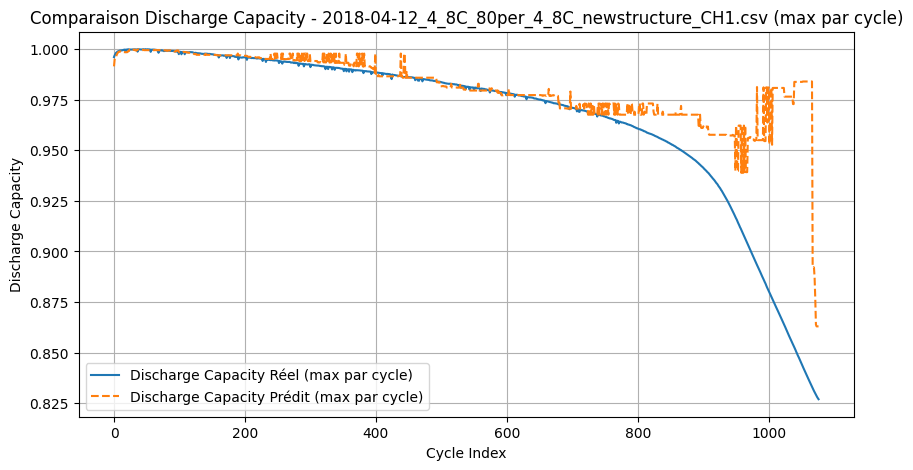

Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH17.csv
Mean Squared Error (MSE): 0.43867645793587695
Mean Absolute Error (MAE): 0.5799164747877809
R-squared (R²): -135.63993331241613


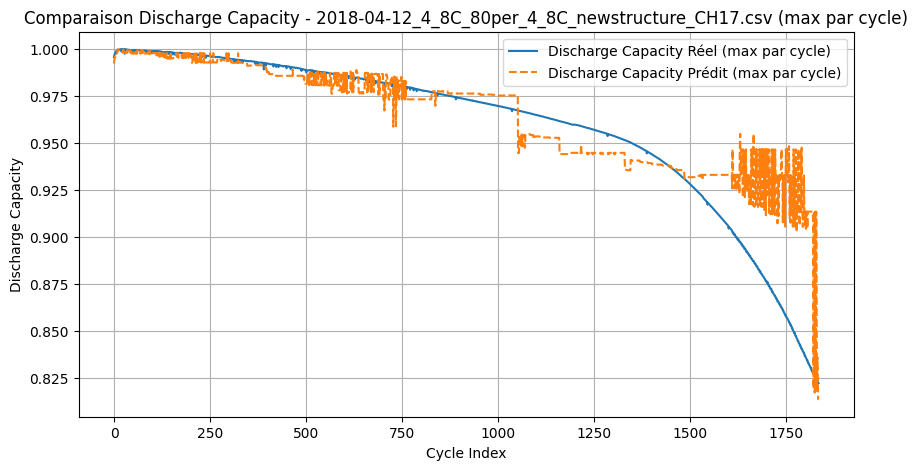

Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH25.csv
Mean Squared Error (MSE): 0.4571230774854354
Mean Absolute Error (MAE): 0.5971952020550192
R-squared (R²): -153.80513750010888


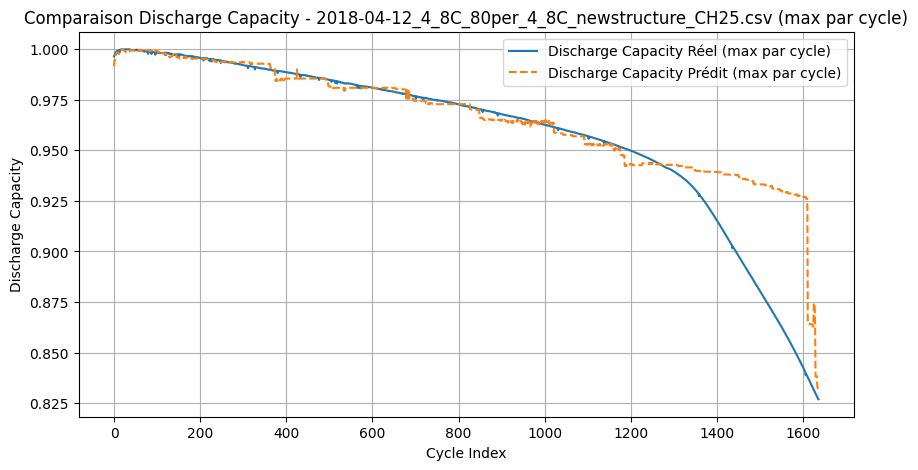

Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH9.csv
Mean Squared Error (MSE): 0.4539577170793892
Mean Absolute Error (MAE): 0.590646899749704
R-squared (R²): -153.1110784282277


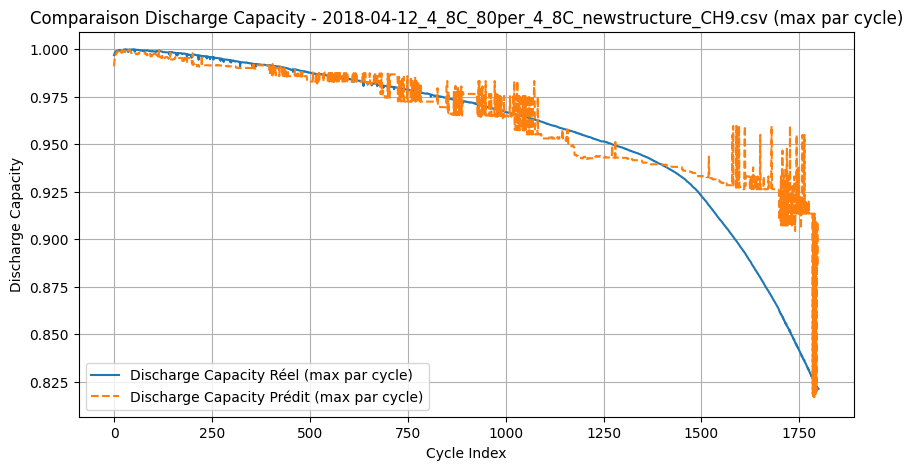

In [4]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib  # Pour enregistrer le modèle

# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'

# Lister tous les fichiers CSV dans le répertoire donné
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Sélectionner les fichiers pour l'entraînement et le test
train_files = csv_files[:12]  # Les 12 premiers fichiers pour l'entraînement
test_files = csv_files[12:]    # Les fichiers restants pour le test

# Initialiser les ensembles de données d'entraînement
X_train_total = []
y_train_total = []

# Préparer les données d'entraînement
for csv_file in train_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    X = df.drop(columns=['Discharge_Capacity'])
    y = df['Discharge_Capacity']  # Appliquer les contraintes
    X_train_total.append(X)
    y_train_total.append(y)

# Concaténer les données d'entraînement
X_train = pd.concat(X_train_total, axis=0)
y_train = pd.concat(y_train_total, axis=0)

# Créer le modèle Random Forest
model_rf = RandomForestRegressor(n_estimators=2, random_state=10)

# Entraîner le modèle
model_rf.fit(X_train, y_train)

# Enregistrer le modèle Random Forest dans le dossier 'Models'
model_path = 'C:\\Users\\pc\\Desktop\\Models\\random_forest_model.pkl'
joblib.dump(model_rf, model_path)

# Créer le répertoire pour enregistrer les résultats s'il n'existe pas déjà
results_dir = 'C:\\Users\\pc\\Desktop\\PHM-BATTERIES\\Results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Tester le modèle sur chaque fichier de test
for csv_file in test_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    X_test = df.drop(columns=['Discharge_Capacity'])
    y_test = df['Discharge_Capacity'].clip(0.8, 1)  # Appliquer les contraintes

    # Faire des prédictions
    rf_pred = model_rf.predict(X_test)

    # Calculer les métriques
    mse = mean_squared_error(y_test, rf_pred)
    mae = mean_absolute_error(y_test, rf_pred)
    r2 = r2_score(y_test, rf_pred)

    # Afficher les résultats
    print(f"Fichier de test: {csv_file}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")

    # Extraire le Cycle_Index
    cycle_index = df['Cycle_Index']

    # Prendre le maximum des prédictions par cycle
    rf_pred_max_per_cycle = pd.Series(rf_pred).groupby(cycle_index).max()

    # Enregistrer les résultats dans un fichier CSV
    results_file_path = os.path.join(results_dir, f'max_discharge_capacity_{csv_file}.csv')
    rf_pred_max_per_cycle.to_csv(results_file_path, header=['Max Discharge Capacity'])

    # Tracer le graphique pour comparer les valeurs réelles et prédites
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.groupby(cycle_index).max(), label='Discharge Capacity Réel (max par cycle)')
    plt.plot(rf_pred_max_per_cycle, label='Discharge Capacity Prédit (max par cycle)', linestyle='--')
    plt.xlabel('Cycle Index')
    plt.ylabel('Discharge Capacity')
    plt.title(f'Comparaison Discharge Capacity - {csv_file} (max par cycle)')
    plt.legend()
    plt.grid(True)
    plt.show()


### Ensemble learning

In [25]:
from sklearn.ensemble import VotingRegressor
import joblib
rf_model = joblib.load('C:\\Users\\pc\\Desktop\\Models\\random_forest_model.pkl')
lr_model = joblib.load('C:\\Users\\pc\\Desktop\\Models\\linear_regression_model.pkl')
xgb_model = xgb.XGBRegressor()
xgb_model.load_model('C:\\Users\\pc\\Desktop\\Models\\xgb.json')
ensemble_model = joblib.load('C:\\Users\\pc\\Desktop\\Models\\ensemble_model.pkl')
# Créer le modèle d'ensemble (si cela n'a pas encore été fait)
ensemble_model = VotingRegressor(estimators=[
    ('rf', rf_model),
    ('lr', lr_model),
    ('xgb', xgb_model)
])

# Entraîner le modèle d'ensemble
ensemble_model.fit(X_train, y_train)

# Enregistrer le modèle d'ensemble dans un fichier
ensemble_model_path = 'C:\\Users\\pc\\Desktop\\Models\\ensemble_model.pkl'
joblib.dump(ensemble_model, ensemble_model_path)


['C:\\Users\\pc\\Desktop\\Models\\ensemble_model.pkl']

Prédictions pour le fichier : 2018-04-12_4_8C_80per_4_8C_CH1.csv
Prédictions pour le fichier : 2018-04-12_4_8C_80per_4_8C_CH17.csv
Prédictions pour le fichier : 2018-04-12_4_8C_80per_4_8C_CH25.csv
Prédictions pour le fichier : 2018-04-12_4_8C_80per_4_8C_CH9.csv


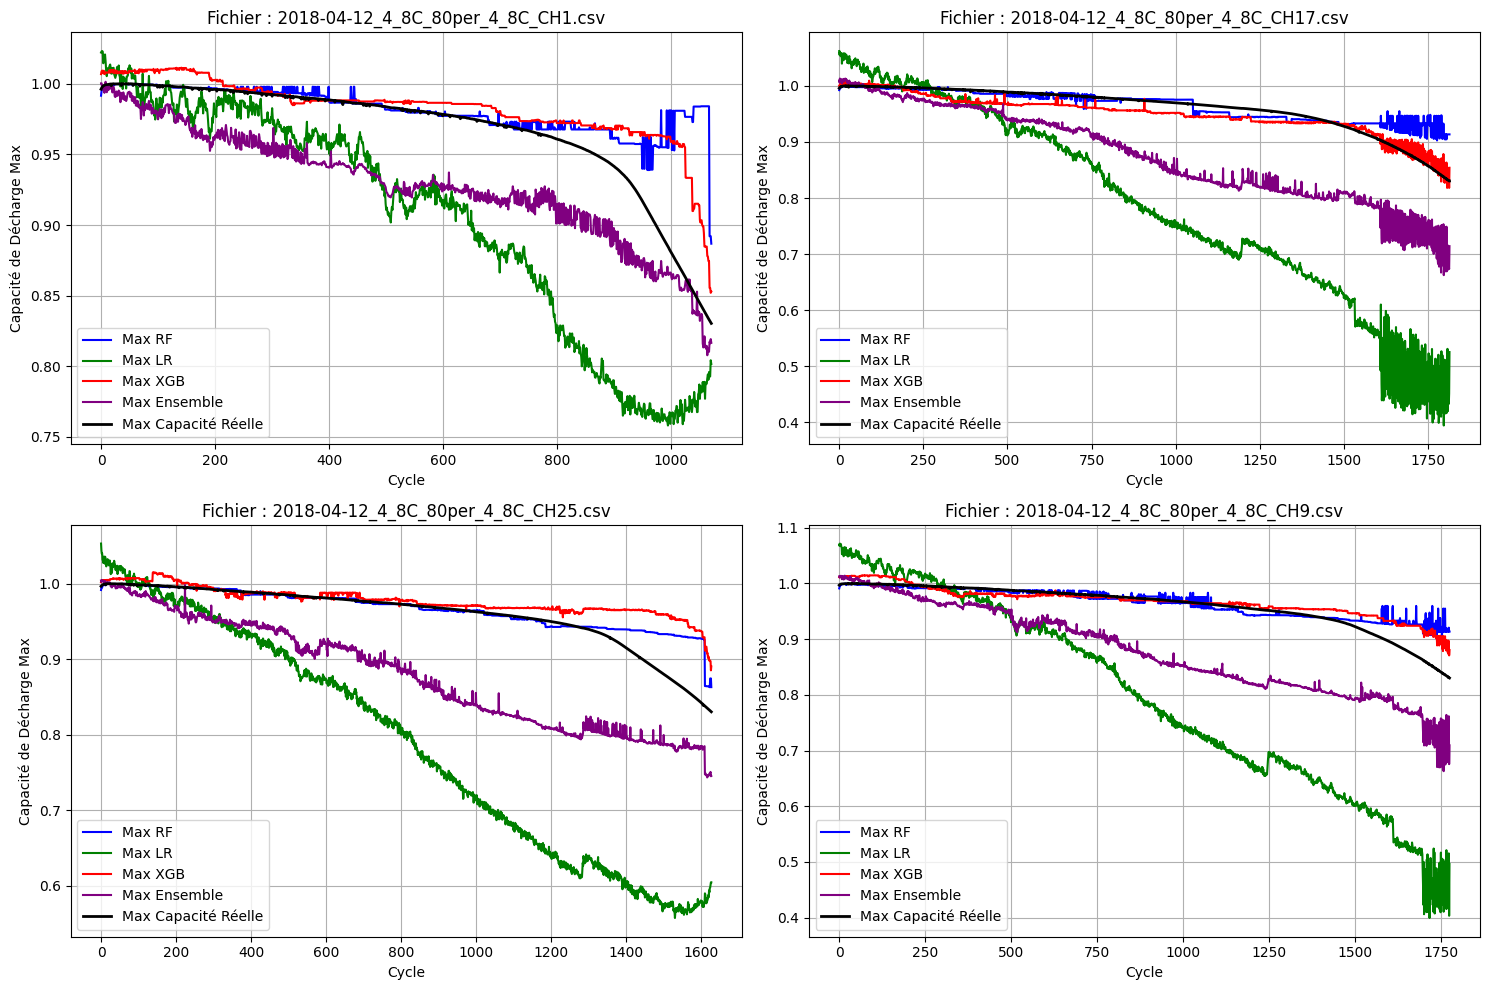


Évaluation moyenne sur les 4 fichiers :
MSE moyen RF : 0.0006522514297706075
RMSE moyen RF : 0.024871745836116028
MSE moyen LR : 0.03592106343610985
RMSE moyen LR : 0.18055311844230582
MSE moyen XGB : 0.000575214645743297
RMSE moyen XGB : 0.023257887673723533
MSE moyen Ensemble : 0.0071800121844316
RMSE moyen Ensemble : 0.08155813057501043


In [3]:
import os
import pandas as pd
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'

# Lister tous les fichiers CSV dans le répertoire donné
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Sélectionner les fichiers pour l'entraînement et le test
train_files = csv_files[:12]  # Les 12 premiers fichiers pour l'entraînement
test_files = csv_files[12:]    # Les fichiers restants pour le test

# Charger les modèles
rf_model = joblib.load('C:\\Users\\pc\\Desktop\\Models\\random_forest_model.pkl')
lr_model = joblib.load('C:\\Users\\pc\\Desktop\\Models\\linear_regression_model.pkl')
xgb_model = xgb.XGBRegressor()
xgb_model.load_model('C:\\Users\\pc\\Desktop\\Models\\xgb.json')
ensemble_model = joblib.load('C:\\Users\\pc\\Desktop\\Models\\ensemble_model.pkl')

# Initialiser les listes pour stocker les erreurs de chaque fichier
mse_rf_list, mse_lr_list, mse_xgb_list, mse_ensemble_list = [], [], [], []
rmse_rf_list, rmse_lr_list, rmse_xgb_list, rmse_ensemble_list = [], [], [], []

# Créer une figure avec plusieurs sous-graphes
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # 2 lignes et 2 colonnes de sous-graphes

# Tester le modèle sur chaque fichier de test
for i, csv_file in enumerate(test_files[:4]):  # Limiter à 4 fichiers pour chaque graphe
    file_path = os.path.join(data_path, csv_file)
    df_test = pd.read_csv(file_path)
    
    # Afficher le nom du fichier en cours de traitement
    print(f"Prédictions pour le fichier : {csv_file}")
    
    # Supposons que tu as une colonne 'Cycle_Index' dans df_test
    cycle_index = df_test['Cycle_Index']  # Remplace par le nom correct de la colonne si nécessaire
    X_test = df_test.drop(columns=['Discharge_Capacity'])
    y_test = df_test['Discharge_Capacity'].clip(0.8, 1)

    # Faire des prédictions
    rf_pred = rf_model.predict(X_test)
    lr_pred = lr_model.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    ensemble_pred = ensemble_model.predict(X_test)

    # Calculer le maximum par cycle pour chaque modèle et les données réelles
    rf_pred_max_per_cycle = pd.Series(rf_pred).groupby(cycle_index).max()
    lr_pred_max_per_cycle = pd.Series(lr_pred).groupby(cycle_index).max()
    xgb_pred_max_per_cycle = pd.Series(xgb_pred).groupby(cycle_index).max()
    ensemble_pred_max_per_cycle = pd.Series(ensemble_pred).groupby(cycle_index).max()
    discharge_capacity_max_per_cycle = df_test.groupby('Cycle_Index')['Discharge_Capacity'].max()

    # Calculer le MSE et RMSE pour chaque modèle en fonction des valeurs maximales par cycle
    mse_rf = mean_squared_error(discharge_capacity_max_per_cycle, rf_pred_max_per_cycle)
    mse_lr = mean_squared_error(discharge_capacity_max_per_cycle, lr_pred_max_per_cycle)
    mse_xgb = mean_squared_error(discharge_capacity_max_per_cycle, xgb_pred_max_per_cycle)
    mse_ensemble = mean_squared_error(discharge_capacity_max_per_cycle, ensemble_pred_max_per_cycle)

    rmse_rf = np.sqrt(mse_rf)
    rmse_lr = np.sqrt(mse_lr)
    rmse_xgb = np.sqrt(mse_xgb)
    rmse_ensemble = np.sqrt(mse_ensemble)

    # Ajouter les erreurs dans les listes
    mse_rf_list.append(mse_rf)
    mse_lr_list.append(mse_lr)
    mse_xgb_list.append(mse_xgb)
    mse_ensemble_list.append(mse_ensemble)

    rmse_rf_list.append(rmse_rf)
    rmse_lr_list.append(rmse_lr)
    rmse_xgb_list.append(rmse_xgb)
    rmse_ensemble_list.append(rmse_ensemble)

    # Sélectionner l'axe correct pour chaque fichier
    ax = axs[i//2, i%2]  # Trouver la position dans la grille 2x2

    # Tracer les prédictions maximales pour chaque modèle sur cet axe
    ax.plot(rf_pred_max_per_cycle.index, rf_pred_max_per_cycle, label='Max RF', color='blue')
    ax.plot(lr_pred_max_per_cycle.index, lr_pred_max_per_cycle, label='Max LR', color='green')
    ax.plot(xgb_pred_max_per_cycle.index, xgb_pred_max_per_cycle, label='Max XGB', color='red')
    ax.plot(ensemble_pred_max_per_cycle.index, ensemble_pred_max_per_cycle, label='Max Ensemble', color='purple')
    
    # Tracer les valeurs maximales réelles de la capacité de décharge
    ax.plot(discharge_capacity_max_per_cycle.index, discharge_capacity_max_per_cycle, label='Max Capacité Réelle', linestyle='-', linewidth=2, color='black')

    # Ajouter un titre et des étiquettes
    ax.set_title(f'Fichier : {csv_file}')
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Capacité de Décharge Max')
    ax.legend()
    ax.grid()

# Ajuster les espaces entre les sous-graphes
plt.tight_layout()

# Afficher la figure avec les 4 graphes
plt.show()

# Calculer la moyenne des MSE et RMSE pour chaque modèle sur les 4 fichiers
mse_rf_mean = np.mean(mse_rf_list)
mse_lr_mean = np.mean(mse_lr_list)
mse_xgb_mean = np.mean(mse_xgb_list)
mse_ensemble_mean = np.mean(mse_ensemble_list)

rmse_rf_mean = np.mean(rmse_rf_list)
rmse_lr_mean = np.mean(rmse_lr_list)
rmse_xgb_mean = np.mean(rmse_xgb_list)
rmse_ensemble_mean = np.mean(rmse_ensemble_list)

# Afficher les résultats moyens
print("\nÉvaluation moyenne sur les 4 fichiers :")
print(f"MSE moyen RF : {mse_rf_mean}")
print(f"RMSE moyen RF : {rmse_rf_mean}")
print(f"MSE moyen LR : {mse_lr_mean}")
print(f"RMSE moyen LR : {rmse_lr_mean}")
print(f"MSE moyen XGB : {mse_xgb_mean}")
print(f"RMSE moyen XGB : {rmse_xgb_mean}")
print(f"MSE moyen Ensemble : {mse_ensemble_mean}")
print(f"RMSE moyen Ensemble : {rmse_ensemble_mean}")


Prédictions pour le fichier : 2018-04-12_4_8C_80per_4_8C_newstructure_CH1.csv


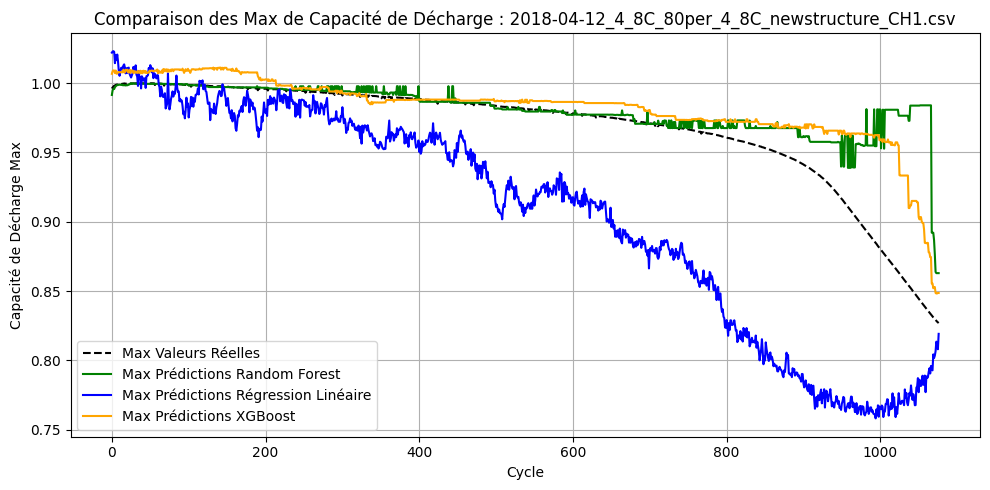

In [5]:
import os
import pandas as pd
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt
import xgboost as xgb

# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'



# Charger les modèles
rf_model = joblib.load('C:\\Users\\pc\\Desktop\\Models\\random_forest_model.pkl')
lr_model = joblib.load('C:\\Users\\pc\\Desktop\\Models\\linear_regression_model.pkl')
xgb_model = xgb.XGBRegressor()
xgb_model.load_model('C:\\Users\\pc\\Desktop\\Models\\xgb.json')

# Charger et traiter uniquement le fichier 13 (le 13e fichier dans la liste)
csv_file = os.listdir(data_path)[12]  # Fichier numéro 13
file_path = os.path.join(data_path, csv_file)
df_test = pd.read_csv(file_path)

# Afficher le nom du fichier en cours de traitement
print(f"Prédictions pour le fichier : {csv_file}")

# Préparer les données de test
cycle_index = df_test['Cycle_Index']
X_test = df_test.drop(columns=['Discharge_Capacity'])
y_test = df_test['Discharge_Capacity'].clip(0.8, 1)

# Faire des prédictions avec chaque modèle
rf_pred = rf_model.predict(X_test)
lr_pred = lr_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Calculer le maximum par cycle pour chaque modèle
rf_pred_max_per_cycle = pd.Series(rf_pred).groupby(cycle_index).max()
lr_pred_max_per_cycle = pd.Series(lr_pred).groupby(cycle_index).max()
xgb_pred_max_per_cycle = pd.Series(xgb_pred).groupby(cycle_index).max()
y_test_max_per_cycle = y_test.groupby(cycle_index).max()  # Maximum des valeurs réelles

# Enregistrer les prédictions dans un fichier CSV
result_df = pd.DataFrame({
    'Cycle_Index': cycle_index.unique(),
    'Max_Real': y_test_max_per_cycle.values,
    'Max_RF_Pred': rf_pred_max_per_cycle.values,
    'Max_LR_Pred': lr_pred_max_per_cycle.values,
    'Max_XGB_Pred': xgb_pred_max_per_cycle.values
})

# Chemin du dossier 'Results' dans le répertoire courant où le code est exécuté
results_path = os.path.join(os.getcwd(), 'Results')

# Vérifier si le dossier 'Results' existe, sinon le créer
if not os.path.exists(results_path):
    os.makedirs(results_path)

# Enregistrer les résultats
result_file = os.path.join(results_path, f'results_{csv_file}')
result_df.to_csv(result_file, index=False)

# Tracer les résultats
plt.figure(figsize=(10, 5))
plt.plot(y_test_max_per_cycle.values, label='Max Valeurs Réelles', color='black', linestyle='--')
rf_pred_max_per_cycle.plot(label='Max Prédictions Random Forest', color='green')
lr_pred_max_per_cycle.plot(label='Max Prédictions Régression Linéaire', color='blue')
xgb_pred_max_per_cycle.plot(label='Max Prédictions XGBoost', color='orange')

# Ajouter un titre et des étiquettes
plt.title(f'Comparaison des Max de Capacité de Décharge : {csv_file}')
plt.xlabel('Cycle')
plt.ylabel('Capacité de Décharge Max')
plt.legend()
plt.grid()
plt.tight_layout()

# Sauvegarder le graphique
plt.savefig(os.path.join(results_path, f'graph_{csv_file}.png'))

# Afficher le graphique
plt.show()


Prédictions pour le fichier : 2018-04-12_4_8C_80per_4_8C_CH17.csv
2018-04-12_4_8C_80per_4_8C_CH17.csv - MSE RF: 0.0005, RMSE RF: 0.0220
2018-04-12_4_8C_80per_4_8C_CH17.csv - MSE LR: 0.0482, RMSE LR: 0.2195
2018-04-12_4_8C_80per_4_8C_CH17.csv - MSE Ensemble: 0.0098, RMSE Ensemble: 0.0992
2018-04-12_4_8C_80per_4_8C_CH17.csv - MSE Ensemble Pondéré: 0.0001, RMSE Ensemble Pondéré: 0.0111
2018-04-12_4_8C_80per_4_8C_CH17.csv - MSE XGBoost: 0.0003, RMSE XGBoost: 0.0162
Prédictions pour le fichier : 2018-04-12_4_8C_80per_4_8C_CH25.csv
2018-04-12_4_8C_80per_4_8C_CH25.csv - MSE RF: 0.0005, RMSE RF: 0.0214
2018-04-12_4_8C_80per_4_8C_CH25.csv - MSE LR: 0.0428, RMSE LR: 0.2069
2018-04-12_4_8C_80per_4_8C_CH25.csv - MSE Ensemble: 0.0083, RMSE Ensemble: 0.0912
2018-04-12_4_8C_80per_4_8C_CH25.csv - MSE Ensemble Pondéré: 0.0001, RMSE Ensemble Pondéré: 0.0116
2018-04-12_4_8C_80per_4_8C_CH25.csv - MSE XGBoost: 0.0010, RMSE XGBoost: 0.0315
Prédictions pour le fichier : 2018-04-12_4_8C_80per_4_8C_CH9.csv
201

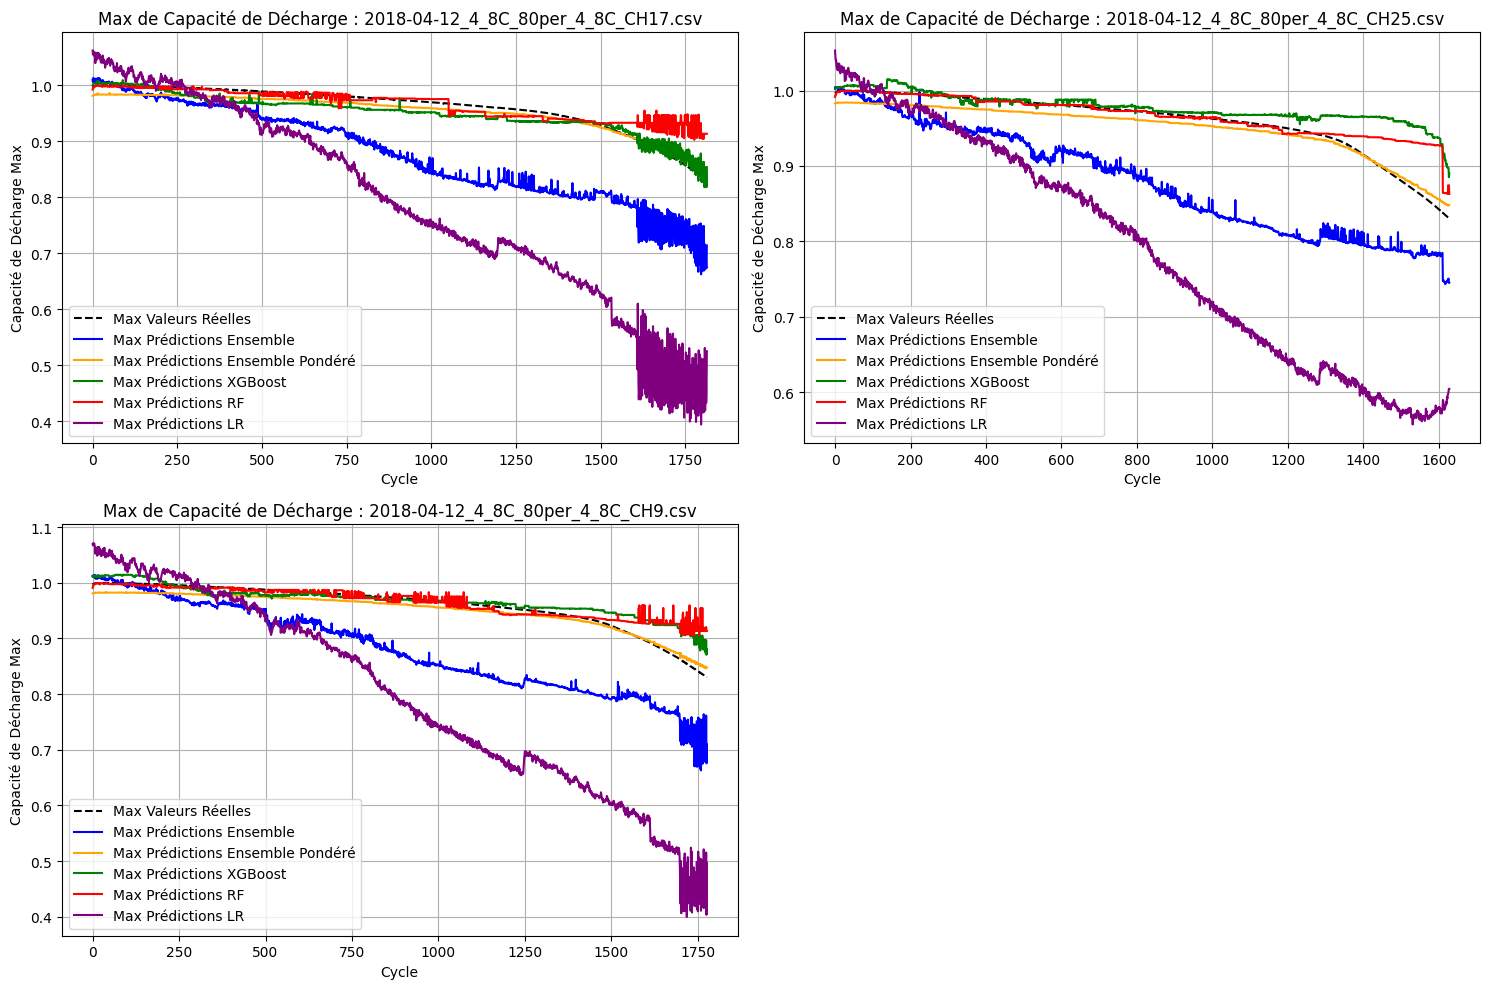

In [4]:
import os
import pandas as pd
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'

# Lister tous les fichiers CSV dans le répertoire donné
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Charger les modèles
rf_model = joblib.load('C:\\Users\\pc\\Desktop\\Models\\random_forest_model.pkl')
lr_model = joblib.load('C:\\Users\\pc\\Desktop\\Models\\linear_regression_model.pkl')
xgb_model = xgb.XGBRegressor()
xgb_model.load_model('C:\\Users\\pc\\Desktop\\Models\\xgb.json')
ensemble_model = joblib.load('C:\\Users\\pc\\Desktop\\Models\\ensemble_model.pkl')

# Pondérer les modèles en fonction de leur performance
weights = [0.01509682, 0.20850005, 0.77640313]  # Ajuster les poids selon la précision des modèles
ensemble_model_weighted = VotingRegressor(estimators=[
    ('rf', rf_model),
    ('lr', lr_model),
    ('xgb', xgb_model)
], weights=weights)

# Créer une figure pour afficher les graphes
plt.figure(figsize=(15, 10))

# Initialiser des accumulations pour le MSE et RMSE généraux
total_mse_rf = 0
total_rmse_rf = 0
total_mse_lr = 0
total_rmse_lr = 0
total_mse_ensemble = 0
total_rmse_ensemble = 0
total_mse_ensemble_weighted = 0
total_rmse_ensemble_weighted = 0
total_mse_xgb = 0
total_rmse_xgb = 0

# Tester le modèle sur chaque fichier de test
for idx, csv_file in enumerate(csv_files[13:]):  # Traiter les fichiers de test (à partir du 14ème)
    file_path = os.path.join(data_path, csv_file)
    df_test = pd.read_csv(file_path)

    # Afficher le nom du fichier en cours de traitement
    print(f"Prédictions pour le fichier : {csv_file}")

    # Préparer les données de test
    cycle_index = df_test['Cycle_Index']
    X_test = df_test.drop(columns=['Discharge_Capacity'])
    y_test = df_test['Discharge_Capacity'].clip(0.8, 1)

    # Entraîner le modèle pondéré
    ensemble_model_weighted.fit(X_test, y_test)

    # Faire des prédictions avec les différents modèles
    ensemble_pred = ensemble_model.predict(X_test)
    ensemble_pred_weighted = ensemble_model_weighted.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    rf_pred = rf_model.predict(X_test)
    lr_pred = lr_model.predict(X_test)

    # Calculer le maximum par cycle pour chaque modèle
    ensemble_pred_max_per_cycle = pd.Series(ensemble_pred).groupby(cycle_index).max()
    ensemble_pred_weighted_max_per_cycle = pd.Series(ensemble_pred_weighted).groupby(cycle_index).max()
    xgb_pred_max_per_cycle = pd.Series(xgb_pred).groupby(cycle_index).max()
    rf_pred_max_per_cycle = pd.Series(rf_pred).groupby(cycle_index).max()
    lr_pred_max_per_cycle = pd.Series(lr_pred).groupby(cycle_index).max()
    y_test_max_per_cycle = y_test.groupby(cycle_index).max()  # Maximum des valeurs réelles

    # Calculer le MSE et RMSE pour chaque modèle
    mse_rf = mean_squared_error(y_test_max_per_cycle, rf_pred_max_per_cycle)
    rmse_rf = np.sqrt(mse_rf)

    mse_lr = mean_squared_error(y_test_max_per_cycle, lr_pred_max_per_cycle)
    rmse_lr = np.sqrt(mse_lr)

    mse_ensemble = mean_squared_error(y_test_max_per_cycle, ensemble_pred_max_per_cycle)
    rmse_ensemble = np.sqrt(mse_ensemble)
    
    mse_ensemble_weighted = mean_squared_error(y_test_max_per_cycle, ensemble_pred_weighted_max_per_cycle)
    rmse_ensemble_weighted = np.sqrt(mse_ensemble_weighted)
    
    mse_xgb = mean_squared_error(y_test_max_per_cycle, xgb_pred_max_per_cycle)
    rmse_xgb = np.sqrt(mse_xgb)

    # Ajouter aux totaux
    total_mse_rf += mse_rf
    total_rmse_rf += rmse_rf
    total_mse_lr += mse_lr
    total_rmse_lr += rmse_lr
    total_mse_ensemble += mse_ensemble
    total_rmse_ensemble += rmse_ensemble
    total_mse_ensemble_weighted += mse_ensemble_weighted
    total_rmse_ensemble_weighted += rmse_ensemble_weighted
    total_mse_xgb += mse_xgb
    total_rmse_xgb += rmse_xgb

    # Afficher le MSE et le RMSE pour chaque fichier
    print(f"{csv_file} - MSE RF: {mse_rf:.4f}, RMSE RF: {rmse_rf:.4f}")
    print(f"{csv_file} - MSE LR: {mse_lr:.4f}, RMSE LR: {rmse_lr:.4f}")
    print(f"{csv_file} - MSE Ensemble: {mse_ensemble:.4f}, RMSE Ensemble: {rmse_ensemble:.4f}")
    print(f"{csv_file} - MSE Ensemble Pondéré: {mse_ensemble_weighted:.4f}, RMSE Ensemble Pondéré: {rmse_ensemble_weighted:.4f}")
    print(f"{csv_file} - MSE XGBoost: {mse_xgb:.4f}, RMSE XGBoost: {rmse_xgb:.4f}")

    # Tracer les résultats dans des sous-graphes
    plt.subplot(2, 2, idx + 1 if idx < 3 else 3)  # 2 lignes, 2 colonnes

    plt.plot(y_test_max_per_cycle.values, label='Max Valeurs Réelles', color='black', linestyle='--')
    ensemble_pred_max_per_cycle.plot(label='Max Prédictions Ensemble', color='blue')
    ensemble_pred_weighted_max_per_cycle.plot(label='Max Prédictions Ensemble Pondéré', color='orange')
    xgb_pred_max_per_cycle.plot(label='Max Prédictions XGBoost', color='green')
    rf_pred_max_per_cycle.plot(label='Max Prédictions RF', color='red')
    lr_pred_max_per_cycle.plot(label='Max Prédictions LR', color='purple')

    # Ajouter un titre et des étiquettes pour chaque sous-graphe
    plt.title(f'Max de Capacité de Décharge : {csv_file}')
    plt.xlabel('Cycle')
    plt.ylabel('Capacité de Décharge Max')
    plt.legend()
    plt.grid()

# Calculer le nombre de fichiers traités
num_files = len(csv_files[13:])

# Calculer le MSE et RMSE généraux
mean_mse_rf = total_mse_rf / num_files
mean_rmse_rf = total_rmse_rf / num_files
mean_mse_lr = total_mse_lr / num_files
mean_rmse_lr = total_rmse_lr / num_files
mean_mse_ensemble = total_mse_ensemble / num_files
mean_rmse_ensemble = total_rmse_ensemble / num_files
mean_mse_ensemble_weighted = total_mse_ensemble_weighted / num_files
mean_rmse_ensemble_weighted = total_rmse_ensemble_weighted / num_files
mean_mse_xgb = total_mse_xgb / num_files
mean_rmse_xgb = total_rmse_xgb / num_files

# Afficher les résultats généraux
print(f"\nMSE Général RF: {mean_mse_rf:.8f}, RMSE Général RF: {mean_rmse_rf:.8f}")
print(f"MSE Général LR: {mean_mse_lr:.8f}, RMSE Général LR: {mean_rmse_lr:.8f}")
print(f"MSE Général Ensemble: {mean_mse_ensemble:.8f}, RMSE Général Ensemble: {mean_rmse_ensemble:.8f}")
print(f"MSE Général Ensemble Pondéré: {mean_mse_ensemble_weighted:.8f}, RMSE Général Ensemble Pondéré: {mean_rmse_ensemble_weighted:.8f}")
print(f"MSE Général XGBoost: {mean_mse_xgb:.8f}, RMSE Général XGBoost: {mean_rmse_xgb:.8f}")

# Ajuster la mise en page et afficher les graphes
plt.tight_layout()
plt.show()


Prédictions pour le fichier : 2018-04-12_4_8C_80per_4_8C_CH17.csv
2018-04-12_4_8C_80per_4_8C_CH17.csv - MSE Ensemble Pondéré: 0.00012404, RMSE Ensemble Pondéré: 0.01113731
Prédictions pour le fichier : 2018-04-12_4_8C_80per_4_8C_CH25.csv
2018-04-12_4_8C_80per_4_8C_CH25.csv - MSE Ensemble Pondéré: 0.00013448, RMSE Ensemble Pondéré: 0.01159662
Prédictions pour le fichier : 2018-04-12_4_8C_80per_4_8C_CH9.csv
2018-04-12_4_8C_80per_4_8C_CH9.csv - MSE Ensemble Pondéré: 0.00013437, RMSE Ensemble Pondéré: 0.01159186

MSE Général Ensemble Pondéré: 0.00013096, RMSE Général Ensemble Pondéré: 0.01144193


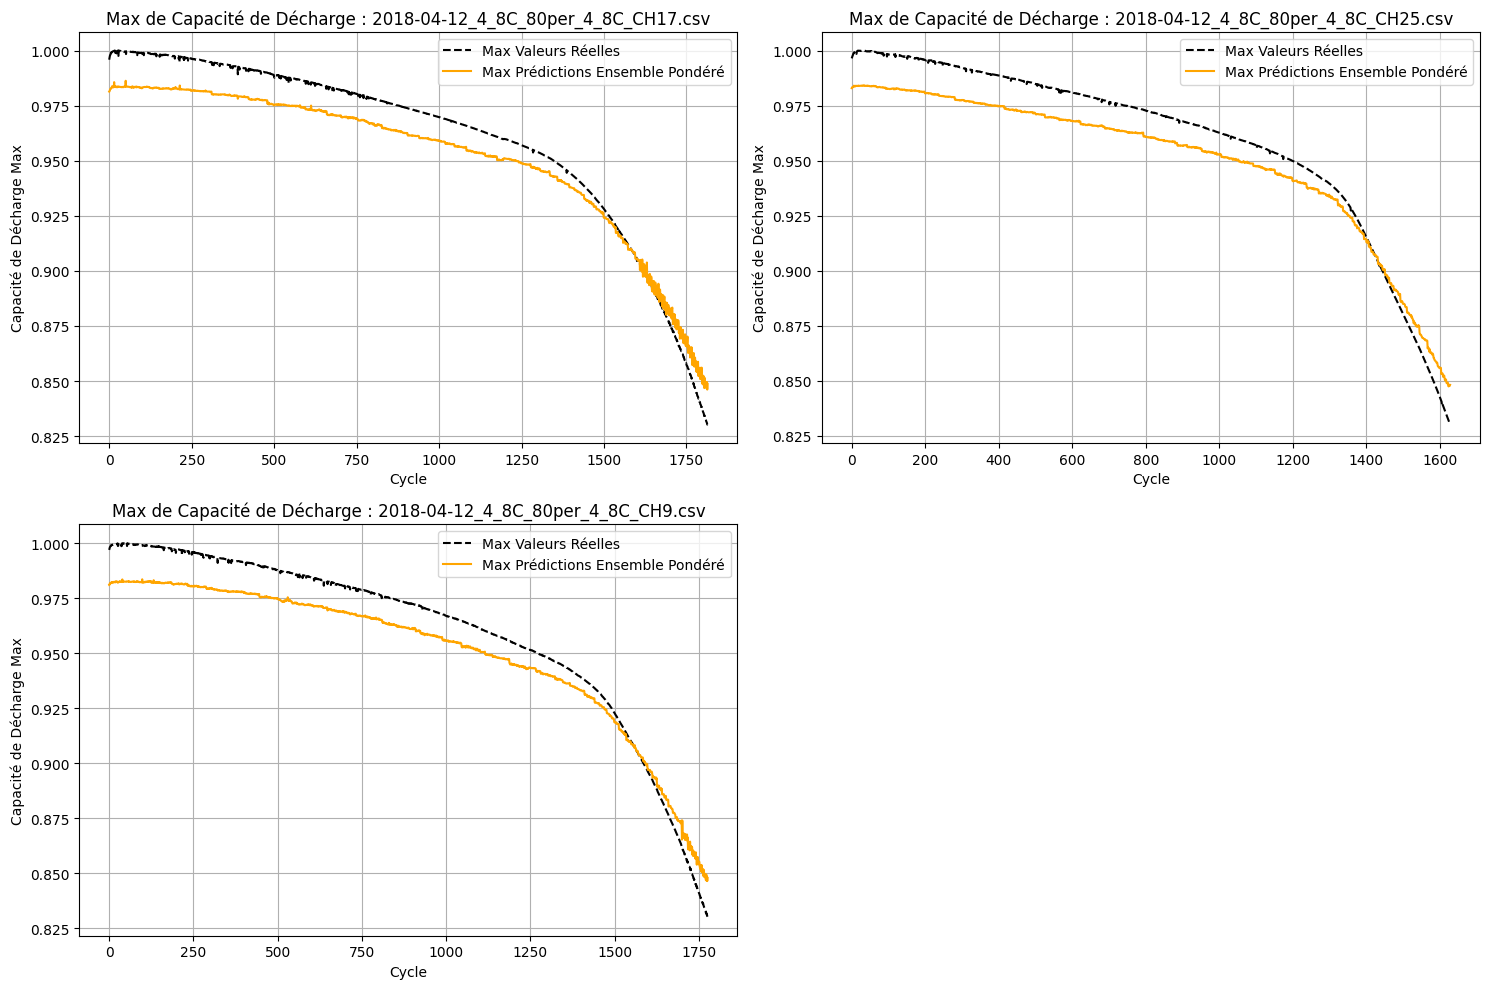

In [2]:
import os
import pandas as pd
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'

# Lister tous les fichiers CSV dans le répertoire donné
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Charger les modèles
rf_model = joblib.load('C:\\Users\\pc\\Desktop\\Models\\random_forest_model.pkl')
lr_model = joblib.load('C:\\Users\\pc\\Desktop\\Models\\linear_regression_model.pkl')
xgb_model = xgb.XGBRegressor()
xgb_model.load_model('C:\\Users\\pc\\Desktop\\Models\\xgb.json')

# Pondérer les modèles en fonction de leur performance
weights = [0.01509682, 0.20850005, 0.77640313]  # Ajuster les poids selon la précision des modèles
ensemble_model_weighted = VotingRegressor(estimators=[
    ('rf', rf_model),
    ('lr', lr_model),
    ('xgb', xgb_model)
], weights=weights)

# Créer une figure pour afficher les graphes
plt.figure(figsize=(15, 10))

# Initialiser des accumulations pour le MSE et RMSE généraux
total_mse_ensemble_weighted = 0
total_rmse_ensemble_weighted = 0 ####

# Tester le modèle sur chaque fichier de test
for idx, csv_file in enumerate(csv_files[13:]):  # Traiter les fichiers de test (à partir du 14ème)
    file_path = os.path.join(data_path, csv_file)
    df_test = pd.read_csv(file_path)

    # Afficher le nom du fichier en cours de traitement
    print(f"Prédictions pour le fichier : {csv_file}")

    # Préparer les données de test
    cycle_index = df_test['Cycle_Index']
    X_test = df_test.drop(columns=['Discharge_Capacity'])
    y_test = df_test['Discharge_Capacity'].clip(0.8, 1)

    # Entraîner le modèle pondéré
    ensemble_model_weighted.fit(X_train, y_train)

    # Faire des prédictions avec le modèle pondéré
    ensemble_pred_weighted = ensemble_model_weighted.predict(X_test)

    # Calculer le maximum par cycle pour le modèle pondéré
    ensemble_pred_weighted_max_per_cycle = pd.Series(ensemble_pred_weighted).groupby(cycle_index).max()
    y_test_max_per_cycle = y_test.groupby(cycle_index).max()  # Maximum des valeurs réelles

    # Calculer le MSE et RMSE pour le modèle pondéré
    mse_ensemble_weighted = mean_squared_error(y_test_max_per_cycle, ensemble_pred_weighted_max_per_cycle)
    rmse_ensemble_weighted = np.sqrt(mse_ensemble_weighted)

    # Ajouter aux totaux
    total_mse_ensemble_weighted += mse_ensemble_weighted
    total_rmse_ensemble_weighted += rmse_ensemble_weighted

    # Afficher le MSE et le RMSE pour chaque fichier
    print(f"{csv_file} - MSE Ensemble Pondéré: {mse_ensemble_weighted:.8f}, RMSE Ensemble Pondéré: {rmse_ensemble_weighted:.8f}")

    # Tracer les résultats dans des sous-graphes
    if idx < 2:  # Pour les deux premiers graphiques, les placer en haut
        plt.subplot(2, 2, idx + 1)  # 2 lignes, 2 colonnes
    else:  # Pour le troisième graphique, le placer en bas et au centre
        plt.subplot(2, 2, 3)  # 2 lignes, 2 colonnes

    plt.plot(y_test_max_per_cycle.values, label='Max Valeurs Réelles', color='black', linestyle='--')
    ensemble_pred_weighted_max_per_cycle.plot(label='Max Prédictions Ensemble Pondéré', color='orange')

    # Ajouter un titre et des étiquettes pour chaque sous-graphe
    plt.title(f'Max de Capacité de Décharge : {csv_file}')
    plt.xlabel('Cycle')
    plt.ylabel('Capacité de Décharge Max')
    plt.legend()
    plt.grid()

# Calculer le nombre de fichiers traités
num_files = len(csv_files[13:])

# Calculer le MSE et RMSE généraux
mean_mse_ensemble_weighted = total_mse_ensemble_weighted / num_files
mean_rmse_ensemble_weighted = total_rmse_ensemble_weighted / num_files

# Afficher les résultats généraux
print(f"\nMSE Général Ensemble Pondéré: {mean_mse_ensemble_weighted:.8f}, RMSE Général Ensemble Pondéré: {mean_rmse_ensemble_weighted:.8f}")

# Ajuster la mise en page et afficher les graphes
plt.tight_layout()
plt.show()


Prédictions pour le fichier : 2018-04-12_4_8C_80per_4_8C_CH17.csv
2018-04-12_4_8C_80per_4_8C_CH17.csv - MSE Ensemble Pondéré: 0.00012404, RMSE Ensemble Pondéré: 0.01113731
Prédictions pour le fichier : 2018-04-12_4_8C_80per_4_8C_CH25.csv
2018-04-12_4_8C_80per_4_8C_CH25.csv - MSE Ensemble Pondéré: 0.00013448, RMSE Ensemble Pondéré: 0.01159662
Prédictions pour le fichier : 2018-04-12_4_8C_80per_4_8C_CH9.csv
2018-04-12_4_8C_80per_4_8C_CH9.csv - MSE Ensemble Pondéré: 0.00013437, RMSE Ensemble Pondéré: 0.01159186

MSE Général Ensemble Pondéré: 0.00013096, RMSE Général Ensemble Pondéré: 0.01144193